In [22]:
import os
import torch

print("Available cores:", os.cpu_count())
if torch.cuda.is_available():
    print("Available GPUs:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])
else:
    print("No GPUs available.")

Available cores: 20
Available GPUs: ['NVIDIA GeForce RTX 4070 Laptop GPU']


In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Setup
NUM_CLUSTERS = 16
NUM_ITER = 10000

# Metric choices
metric_clusters = "max_distance_from_centroid"
metric_clustering = "max_of_metric_clusters"
minimize = True  # Minimize the metric

# import csv
# points = np.genfromtxt('authors_list.csv', delimiter=',', skip_header=1, usecols=(2, 3))
points = np.genfromtxt('authors_list_mpnet.csv', delimiter=',', skip_header=1, usecols=(2, 3))
num_points = points.shape[0]

# Initial assignments and centroids
assignments = np.zeros(num_points, dtype=int)
centroids = np.zeros((NUM_CLUSTERS, 2))
metrics = np.zeros(NUM_CLUSTERS)

print(num_points, NUM_CLUSTERS)

for i in range(NUM_CLUSTERS):
    indices = np.random.choice(range(num_points), size=NUM_CLUSTERS, replace=False)
    assignments[indices] = i
    centroids[i] = np.mean(points[indices], axis=0)

# Clustering iterations
for _ in range(NUM_ITER):
    # Update assignments

plt.figure(figsize=(8, 8))
colors = plt.cm.viridis(np.linspace(0, 1, NUM_CLUSTERS))
for i in range(NUM_CLUSTERS):
    cluster_points = points[assignments == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=50, color=colors[i], label=f'Cluster {i}')
    plt.scatter(centroids[i, 0], centroids[i, 1], s=200, marker='X', color=colors[i], edgecolor='black')
    circle = plt.Circle((centroids[i, 0], centroids[i, 1]), max(metrics[i], 0.1), color=colors[i], fill=False, linewidth=2)
    plt.gca().add_patch(circle)
    plt.text(centroids[i, 0], centroids[i, 1], str(i), color='white', fontsize=12, ha='center', va='center')

plt.title('Clustering Results')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend(title="Clusters", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)
plt.show()


IndentationError: expected an indented block after 'for' statement on line 31 (3276938022.py, line 34)

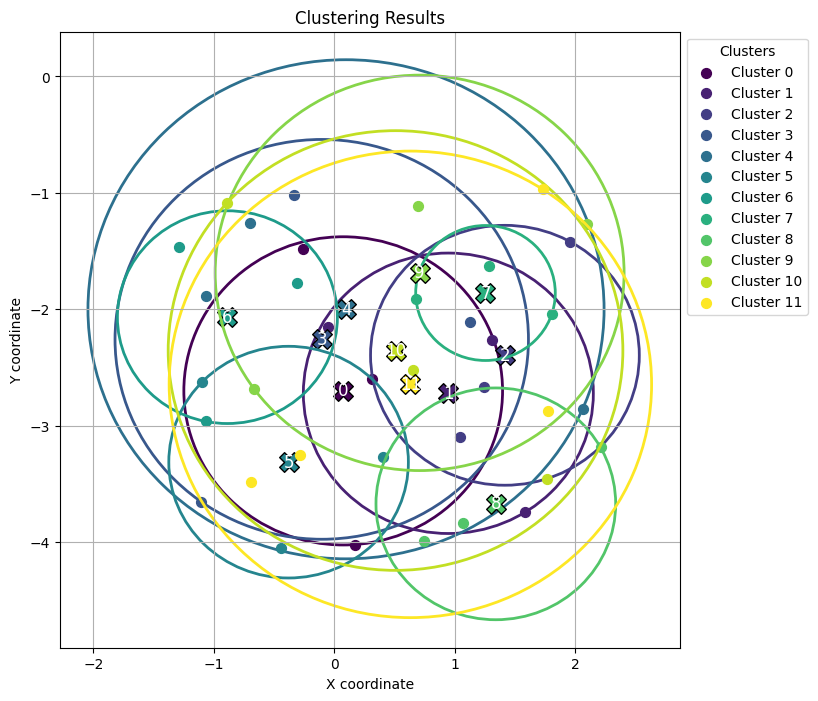

In [129]:
import numpy as np
import matplotlib.pyplot as plt

# Metric choices
metric_clusters = "max_distance_from_centroid"
metric_clustering = "max_of_metric_clusters"
minimize = True  # Minimize the metric

# import csv
# points = np.genfromtxt('authors_list.csv', delimiter=',', skip_header=1, usecols=(2, 3))
points = np.genfromtxt('authors_list_mpnet.csv', delimiter=',', skip_header=1, usecols=(2, 3))

# write here
# centroids, metrics should be set

plt.figure(figsize=(8, 8))
colors = plt.cm.viridis(np.linspace(0, 1, NUM_CLUSTERS))
for i in range(NUM_CLUSTERS):
    cluster_points = points[assignments == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=50, color=colors[i], label=f'Cluster {i}')
    plt.scatter(centroids[i, 0], centroids[i, 1], s=200, marker='X', color=colors[i], edgecolor='black')
    circle = plt.Circle((centroids[i, 0], centroids[i, 1]), max(metrics[i], 0.1), color=colors[i], fill=False, linewidth=2)
    plt.gca().add_patch(circle)
    plt.text(centroids[i, 0], centroids[i, 1], str(i), color='white', fontsize=12, ha='center', va='center')

plt.title('Clustering Results')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend(title="Clusters", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)
plt.show()


In [31]:
import time
import pulp
import numpy as np
import matplotlib.pyplot as plt

# seed値の固定
np.random.seed(0)

num_points = 16
points = np.random.rand(num_points, 2)

# 各ポイントのインデックス
I = range(len(points))

# モデルの定義
model = pulp.LpProblem("Clustering", pulp.LpMinimize)

# 変数の定義: x[i][j] はポイントiがクラスタjに含まれる場合1、そうでない場合0
K = len(points) // 4  # 大まかなクラスタ数
x = pulp.LpVariable.dicts("x", (I, range(K)), cat='Binary')

# 各クラスタのサイズが3または4であることの制約
# for j in range(K):
#     model += (3 <= pulp.lpSum(x[i][j] for i in I) <= 4)

# 各クラスタのサイズが4であることの制約
for j in range(K):
    model += (pulp.lpSum(x[i][j] for i in I) == 4)


# 全てのポイントが1つのクラスタにのみ割り当てられる制約
for i in I:
    model += (pulp.lpSum(x[i][j] for j in range(K)) == 1)

# 目的関数: 各クラスタ内の最大距離の最大値を最小化
D = pulp.LpVariable("D", lowBound=0)

for j in range(K):
    for i in I:
        for m in I:
            if m > i:
                dist = np.linalg.norm(np.array(points[i]) - np.array(points[m]))
                model += (D >= dist * (x[i][j] + x[m][j] - 1))

model += D  # 最小化する目的関数

solver = pulp.PULP_CBC_CMD(threads=20) # スレッド数を指定

start = time.time()
status = model.solve(solver)
elapsed_time = time.time() - start

print("Elapsed time:", elapsed_time)
print("Status:", pulp.LpStatus[status])
print("最小化された最大距離の最大値:", pulp.value(D))
for j in range(K):
    cluster = [points[i] for i in I if pulp.value(x[i][j]) == 1]
    if cluster:
        print(f"クラスタ {j+1}: {cluster}")

plt.figure(figsize=(8, 8))
colors = plt.cm.viridis(np.linspace(0, 1, K))
for j in range(K):
    cluster = [points[i] for i in I if pulp.value(x[i][j]) == 1]
    cluster = np.array(cluster)
    plt.scatter(cluster[:, 0], cluster[:, 1], s=50, color=colors[j], label=f'Cluster {j+1}')

plt.title('Clustering Results')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend(title="Clusters", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)
plt.show()



/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: Input vector should be 1-D.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pulp
from scipy.spatial import distance




# サンプルポイント
points = 
# ポイントの数に基づいてクラスタの数を定義
n_clusters = len(points) // 4

# 線形計画問題を初期化
prob = pulp.LpProblem("OptimalClustering", pulp.LpMinimize)

# 各ポイントとクラスタの組み合わせに変数を割り当て
x = pulp.LpVariable.dicts("point_in_cluster",
                            [(i, j) for i in range(len(points)) for j in range(n_clusters)],
                            cat=pulp.LpBinary)

# 目的関数：クラスタ中心からの距離の総和を最小化
centroid_vars = pulp.LpVariable.dicts("centroid",
                                        [(j, dim) for j in range(n_clusters) for dim in range(2)],
                                        lowBound=None, upBound=None, cat=pulp.LpContinuous)

def calc_distance(point_index, cluster_index):
    point = np.array(points[point_index])
    centroid = np.array([centroid_vars[(cluster_index, 0)], centroid_vars[(cluster_index, 1)]])
    return distance.euclidean(point, centroid)

# 目的関数の設定
prob += pulp.lpSum(x[(i, j)] * calc_distance(i, j) for i in range(len(points)) for j in range(n_clusters))

# 制約条件：各ポイントは1つのクラスタにのみ属する
for i in range(len(points)):
    prob += pulp.lpSum(x[(i, j)] for j in range(n_clusters)) == 1

# 制約条件：各クラスタは4つのポイントを持つ
for j in range(n_clusters):
    prob += pulp.lpSum(x[(i, j)] for i in range(len(points))) == 4

# 重心の制約条件を設定
for j in range(n_clusters):
    for dim in range(2):
        prob += centroid_vars[(j, dim)] == pulp.lpSum(points[i][dim] * x[(i, j)] for i in range(len(points))) / 4

# 問題を解決
solver = pulp.GUROBI_CMD(msg=True, threads=0)
prob.solve(solver)

# クラスタリング結果を抽出して視覚化
clusters = [[] for _ in range(n_clusters)]
for i in range(len(points)):
    for j in range(n_clusters):
        if pulp.value(x[(i, j)]) == 1:
            clusters[j].append(points[i])

plt.figure(figsize=(8, 8))
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))
for j in range(n_clusters):
    cluster = np.array(clusters[j])
    plt.scatter(cluster[:, 0], cluster[:, 1], s=50, color=colors[j], label=f'Cluster {j+1}')

plt.title('Clustering Results')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend(title="Clusters", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)
plt.show()

return clusters



TypeError: unsupported operand type(s) for ** or pow(): 'LpAffineExpression' and 'int'

In [41]:
from scipy.optimize import linprog
import numpy as np

def solve_clusters(points):
    # 問題のサイズ設定
    num_points = len(points)
    num_clusters = num_points // 4
    dist_matrix = np.zeros((num_points, num_points))

    # 距離行列を計算
    for i in range(num_points):
        for j in range(i+1, num_points):
            dist = np.linalg.norm(np.array(points[i]) - np.array(points[j]))
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist

    # 各クラスタにおける総距離を最小化するための目的関数の係数ベクトルを作成
    c = []
    for i in range(num_clusters):
        for j in range(num_points):
            for k in range(j+1, num_points):
                c.append(dist_matrix[j, k])

    # 制約条件：各点が正確に1つのクラスタに属する
    A_eq = np.zeros((num_points, len(c)))
    row = 0
    for i in range(num_clusters):
        for j in range(num_points):
            for k in range(j+1, num_points):
                if j == row:
                    A_eq[j, i*(num_points*(num_points-1)//2) + k - 1] = 1
                if k == row:
                    A_eq[k, i*(num_points*(num_points-1)//2) + k - 1] = 1
        row += 1

    b_eq = np.ones(num_points)  # 各点は1つのクラスタに属する
    bounds = [(0, 1) for _ in c]  # 変数の範囲は0から1

    # 線形計画問題を解く
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    # 結果の解析
    if result.success:
        solution = result.x
        clusters = [[] for _ in range(num_clusters)]
        index = 0
        for i in range(num_clusters):
            for j in range(num_points):
                for k in range(j+1, num_points):
                    if solution[index] > 0.5:  # 閾値を超えた場合、そのクラスタに点を追加
                        clusters[i].append(j)
                        clusters[i].append(k)
                    index += 1
        return clusters
    else:
        return "解を見つけることができませんでした。"

# テストデータ
points = [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 16)]

solve_clusters(points)


'解を見つけることができませんでした。'

In [6]:
# 必要なライブラリをインポート
import pulp
import random

# パラメータ設定
N = 120          # 学生の総数
K = 3            # クラスの数
N_k = N // K     # 各クラスの学生数（40人）

# 学生の成績をランダムに生成（50点から100点の間）
random.seed(0)  # 再現性のためにシードを固定
S = [random.randint(1, 100) for _ in range(N)]
# 学生のインデックスを1から始める
points = list(range(1, N + 1))
classes = list(range(1, K + 1))

# 全体の平均成績を計算
mu = sum(S) / N
M_k = N_k * mu

# 問題を定義
prob = pulp.LpProblem("Class_Assignment_Problem", pulp.LpMinimize)

# 決定変数 x_{i,k}
x = pulp.LpVariable.dicts("x", [(i, k) for i in points for k in classes], cat='Binary')

# 連続変数 δ_k'
delta = pulp.LpVariable.dicts("delta", classes, lowBound=0, cat='Continuous')

# 目的関数：ばらつきを最小化
prob += pulp.lpSum([delta[k] for k in classes]), "Total_Deviation"

# 制約1：各学生は1つのクラスにのみ割り当てられる
for i in points:
    prob += pulp.lpSum([x[(i, k)] for k in classes]) == 1, f"OneClassPerStudent_{i}"

# 制約2：各クラスの学生数は等しい（40人）
for k in classes:
    prob += pulp.lpSum([x[(i, k)] for i in points]) == N_k, f"EqualClassSize_{k}"

# 制約3と4：クラスの総成績と偏差の定義
for k in classes:
    A_k = pulp.lpSum([S[i - 1] * x[(i, k)] for i in points])
    prob += delta[k] >= A_k - M_k, f"Deviation_Positive_{k}"
    prob += delta[k] >= M_k - A_k, f"Deviation_Negative_{k}"

# 問題を解く（Gurobi）
solver = pulp.GUROBI_CMD()
prob.solve(solver)

# 結果の表示
print("最適解のステータス:", pulp.LpStatus[prob.status])
print("目的関数値（総偏差）:", pulp.value(prob.objective))

# 各クラスの学生と平均成績を表示
for k in classes:
    class_points = [i for i in points if pulp.value(x[(i, k)]) == 1]
    class_scores = [S[i - 1] for i in class_points]
    print(f"\nクラス {k}:")
    print(" 学生数:", len(class_points))
    print(" 平均成績:", sum(class_scores) / N_k)
    print(" 学生一覧:", class_points)


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2565624
Set parameter LogFile to value "gurobi.log"
Using license file /opt/gurobi/gurobi.lic
Academic license 2565624 - for non-commercial use only - registered to ur___@g.ecc.u-tokyo.ac.jp

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")
Copyright (c) 2023, Gurobi Optimization, LLC

Read LP format model from file /tmp/cd94f11ef3c44f5db164c0d0a773c68e-pulp.lp
Reading time = 0.00 seconds
Total_Deviation: 129 rows, 363 columns, 1446 nonzeros

CPU model: 13th Gen Intel(R) Core(TM) i9-13900H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Academic license 2565624 - for non-commercial use only - registered to ur___@g.ecc.u-tokyo.ac.jp
Optimize a model with 129 rows, 363 columns and 1446 nonzeros
Model fingerprint: 0xe98fce93
Variable types: 3 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix

In [ ]:
# 必要なライブラリをインポート
import pulp
import random

# パラメータ設定
N = 120          # 学生の総数
K = 3            # クラスの数
N_k = N // K     # 各クラスの学生数（40人）

# 学生の成績をランダムに生成（50点から100点の間）
random.seed(0)  # 再現性のためにシードを固定
S = [random.randint(1, 100) for _ in range(N)]
# 学生のインデックスを1から始める
points = list(range(1, N + 1))
classes = list(range(1, K + 1))

# 全体の平均成績を計算
mu = sum(S) / N
M_k = N_k * mu

# 問題を定義
prob = pulp.LpProblem("Class_Assignment_Problem", pulp.LpMinimize)

# 決定変数 x_{i,k}
x = pulp.LpVariable.dicts("x", [(i, k) for i in points for k in classes], cat='Binary')

# 連続変数 δ_k'
delta = pulp.LpVariable.dicts("delta", classes, lowBound=0, cat='Continuous')

# 目的関数：ばらつきを最小化
prob += pulp.lpSum([delta[k] for k in classes]), "Total_Deviation"

# 制約1：各学生は1つのクラスにのみ割り当てられる
for i in points:
    prob += pulp.lpSum([x[(i, k)] for k in classes]) == 1, f"OneClassPerStudent_{i}"

# 制約2：各クラスの学生数は等しい（40人）
for k in classes:
    prob += pulp.lpSum([x[(i, k)] for i in points]) == N_k, f"EqualClassSize_{k}"

# 制約3と4：クラスの総成績と偏差の定義
for k in classes:
    A_k = pulp.lpSum([S[i - 1] * x[(i, k)] for i in points])
    prob += delta[k] >= A_k - M_k, f"Deviation_Positive_{k}"
    prob += delta[k] >= M_k - A_k, f"Deviation_Negative_{k}"

# 問題を解く（Gurobi）
solver = pulp.GUROBI_CMD()
prob.solve(solver)

# 結果の表示
print("最適解のステータス:", pulp.LpStatus[prob.status])
print("目的関数値（総偏差）:", pulp.value(prob.objective))

# 各クラスの学生と平均成績を表示
for k in classes:
    class_points = [i for i in points if pulp.value(x[(i, k)]) == 1]
    class_scores = [S[i - 1] for i in class_points]
    print(f"\nクラス {k}:")
    print(" 学生数:", len(class_points))
    print(" 平均成績:", sum(class_scores) / N_k)
    print(" 学生一覧:", class_points)


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i9-13900H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Academic license 2565624 - for non-commercial use only - registered to ur___@g.ecc.u-tokyo.ac.jp
Optimize a model with 47 rows, 370 columns and 740 nonzeros
Model fingerprint: 0x8b0cae88
Model has 6660 quadratic objective terms
Variable types: 0 continuous, 370 integer (370 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-01, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 82.2119139
Presolve time: 0.01s
Presolved: 6707 rows, 7030 columns, 20720 nonzeros
Variable types: 0 continuous, 7030 integer (7030 binary)

Root relaxation: objective 0.000000e+00, 362 iterations, 0.02 seconds (0.03 work units)

    Nodes    

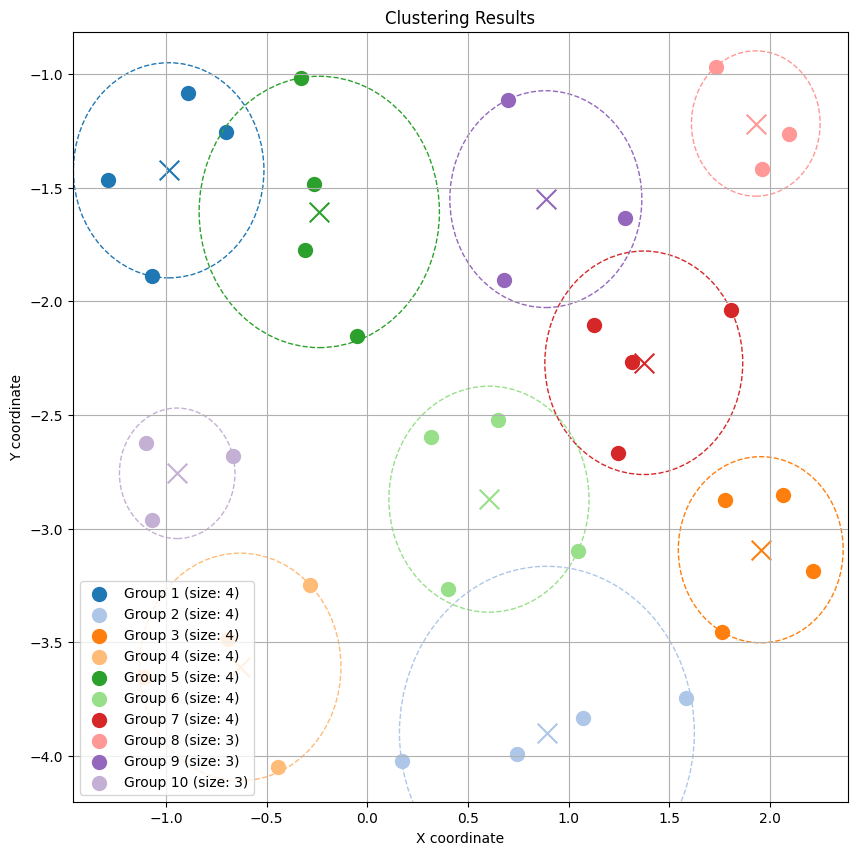

In [28]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# データの読み込み
data = np.genfromtxt('aip-clustering/authors_list_mpnet.csv', delimiter=',', skip_header=1, usecols=(1, 2, 3))
N = data.shape[0]

# グループの設定
num_group_of_4 = 7  # 4人グループの数
num_group_of_3 = 3  # 3人グループの数
G = num_group_of_4 + num_group_of_3  # 総グループ数

# ポイント数の確認
assert N == num_group_of_4 * 4 + num_group_of_3 * 3, "ポイント数がグループの総人数と一致しません。"

# グループサイズのリストを作成
group_sizes = [4]*num_group_of_4 + [3]*num_group_of_3  # グループサイズのリスト

points = range(N)
groups = range(G)

author_name = data[:, 0]
x_coords = data[:, 1]
y_coords = data[:, 2]

# 距離行列の計算
D = np.zeros((N, N))
for i in points:
    for j in points:
        D[i, j] = np.hypot(x_coords[i] - x_coords[j], y_coords[i] - y_coords[j])

# モデルの作成
m = gp.Model("Grouping")

# 決定変数 x_{i,k}
x = m.addVars(points, groups, vtype=GRB.BINARY, name="x")

# 目的関数の設定
obj = gp.quicksum(D[i, j] * x[i, k] * x[j, k] * 0.5
                  for k in groups for i in points for j in points if i != j)
m.setObjective(obj, GRB.MINIMIZE)

# 制約1：各ポイントは1つのグループにのみ割り当てられる
for i in points:
    m.addConstr(gp.quicksum(x[i, k] for k in groups) == 1, name=f"Assign_{i}")

# 制約2：各グループのポイント数は指定されたサイズと等しい
for k in groups:
    m.addConstr(gp.quicksum(x[i, k] for i in points) == group_sizes[k], name=f"GroupSize_{k}")

# 最適化の実行
m.optimize()

# 結果の表示とプロット
if m.status == GRB.OPTIMAL:
    print("\n最適解が見つかりました。")
    # カラーマップの設定
    cmap = plt.get_cmap('tab20')  # 20色のカラーマップ
    colors = [cmap(i) for i in range(G)]
    
    plt.figure(figsize=(10, 10))
    # plt.scatter(x_coords, y_coords, c='gray', s=50, label='ポイント')
    
    for k in groups:
        group_points = [i for i in points if x[i, k].X > 0.5]
        group_coords = coordinates[group_points]
        # グループ内の重心を計算
        centroid = np.mean(group_coords, axis=0)
        # 重心から各ポイントまでの距離を計算し、最大値を取得
        distances = np.linalg.norm(group_coords - centroid, axis=1)
        radius = np.max(distances)
        # グループの色を決定
        color = colors[k % len(colors)]
        # グループのポイントをプロット
        plt.scatter(group_coords[:, 0], group_coords[:, 1], c=[color], s=100, label=f'Group {k+1} (size: {group_sizes[k]})')
        # 円を描画
        circle = plt.Circle((centroid[0], centroid[1]), radius, color=color, fill=False, linestyle='--')
        plt.gca().add_artist(circle)
        # 重心をプロット
        plt.scatter(centroid[0], centroid[1], c=[color], marker='x', s=200)
        
        print(f"\nGroup {k+1}:")
        print(f" ID: {group_points}")
        # グループ内の総距離を計算
        total_distance = 0
        for i in range(len(group_points)):
            for j in range(i+1, len(group_points)):
                idx_i = group_points[i]
                idx_j = group_points[j]
                total_distance += D[idx_i, idx_j]
        print(f" total distance: {total_distance}")
    
    plt.title('Clustering Results')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("最適解が見つかりませんでした。")


aip-clustering	requirements.txt
